# Instalación de recursos


In [ ]:
!pip uninstall -y torch

In [ ]:
# instalación de dependencias
!pip install -U torch==1.5.0 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# instalamos resnest
!python -m pip install 'git+https://github.com/zhanghang1989/detectron2-ResNeSt.git'

In [ ]:
# descargamos el repositorio
!wget https://github.com/zhanghang1989/detectron2-ResNeSt/archive/resnest.zip
!unzip resnest.zip

In [ ]:
%cd /content/detectron2-ResNeSt-resnest
!python setup.py install
!python setup.py develop

In [ ]:
!pip uninstall -y opencv-python
!apt install libopencv-dev python3-opencv

In [ ]:
%cd /content
!git clone https://github.com/open-mmlab/mmcv.git
%cd mmcv
!MMCV_WITH_OPS=1 pip install -e .  # package mmcv-full will be installed after this step
%cd ..
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirements/build.txt
!pip install -v -e .  # or "python setup.py develop"

In [ ]:
 # fuerza el reinicio del entorno. También es posible con CTRL + M
import os
os.kill(os.getpid(), 9)

# Código

In [1]:
# definimos una función encargada de predecir la imagen según el tipo de modelo que estemos usando 
from demo.predictor import VisualizationDemo
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from google.colab.patches import cv2_imshow
from google.colab import output
from scipy.spatial import distance as dist
import numpy as np
import cv2

def run_predictions(cfgPath, typeModel, imagepath, model_path):
  if typeModel == 'resnest':
    print(cfgPath)
    cfg = getCfg(cfgPath, model_path)
    img = read_image(imagepath, format="BGR")
    demo = VisualizationDemo(cfg) ## añadir modelo como parámetro sobreescribiendo el archivo de configuración
    predictions, visualized_output = demo.run_on_image(img)
    visualized_output.save('out.jpg')
    return predictions
  else:
    if typeModel == 'detectors':
      model = init_detector(config_path, model_path, device='cuda:0')
      bbox_result = inference_detector(model, imagepath)
      model.show_result(imagepath, bbox_result, score_thr=0.5, out_file='out.jpg')

      bboxes = np.vstack(bbox_result)
      labels = [
          np.full(bbox.shape[0], i, dtype=np.int32)
          for i, bbox in enumerate(bbox_result)
      ]
      labels = np.concatenate(labels)
      bbox_aux = []
      labelsAux = []
      for l in range(len(labels)):
        if labels[l] == 0 and bboxes[l].tolist()[4] >= 0.5:
          bbox_aux.append(bboxes[l].tolist())
          labelsAux.append(labels[l])
      return dict(bbox=bbox_aux, cat=labelsAux)
    else:
      print('Error')

#función encargada de cargar la configuración para resnest
def getCfg(conf_path, model_path=None):
    cfg = get_cfg()
    cfg.merge_from_file(conf_path)
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
    cfg.MODEL.WEIGHTS = model_path
    cfg.freeze()
    return cfg

def calculate_centroids(predictions, modelType='resnest'):
  if(modelType == 'resnest'):
    classes = predictions['instances'].pred_classes.cpu().numpy()
    centroids = predictions['instances'].pred_boxes.get_centers().cpu().numpy()
    personsCentroids = []
    for c in range(len(centroids)):
      if classes[c] == 0:
        personsCentroids.append(centroids[c].tolist())
    return personsCentroids
  else:
    if modelType == 'detectors':
      centroids = []
      for c in predictions['bbox']:
        dims = [c[0], c[1], c[2], c[3]]
        centroids.append([(dims[0]+dims[2])/2, (dims[1]+dims[3])/2])
      return centroids
    else:
      print('ERROR: wrong model!')

def get_image_position():
  obj = input('Choose an object by displayed labels.')
  h = input('Choose custom width for object selected.')
  return obj, h

def get_reference_object(centroids):
 
  img = cv2.imread('/content/out.jpg')
  cont = 0
  for c in centroids:
    print(c)
    img = cv2.putText(img, str(cont), (int(c[0]), int(c[1])), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)
    cont = cont + 1
  cv2_imshow(img)
  img_reference_xy, h = get_image_position()
  output.clear()
  return (img_reference_xy, h)

def calculate_distances(persons, ref_position, ref_w, preds, typeModel="resnest"):
  pixelPerMetric = calculateMetric(ref_position, ref_w, preds, typeModel)
  results = []
  for p in range(len(persons)):
    distances = []
    for others in range(len(persons)):
      if p != others:
        distances.append({'obj': others, 'dist': dist.euclidean((persons[p][0], persons[p][1]), (persons[others][0], persons[others][1])) / pixelPerMetric})
    results.append({'fromObject': p, 'distances': distances})


  return results

def calculateWidths(predictions, modelType='resnest'):
  if modelType == 'resnest':
    classes = predictions['instances'].pred_classes.cpu().numpy()
    boxes = []
    for b in predictions['instances'].pred_boxes:
      boxes.append(b.cpu().numpy())
    widths = []
    for i in range(len(classes)):
      if classes[i] == 0:
        widths.append(dist.euclidean( (boxes[i][0], boxes[i][1]) , (boxes[i][2], boxes[i][1]) ) )
    return widths
  else:
    if modelType == 'detectors':
      boxes = predictions['bbox']
      widths = []
      for box in boxes:
        widths.append(dist.euclidean( (box[0], box[1]) , (box[2], box[1]) ) )
      return widths

def calculateMetric(ref_position, ref_w, predictions, typeModel):
  widths = calculateWidths(predictions, typeModel)
  return widths[int(ref_position)] / float(ref_w) 

def drawDistances(out_filename, results, persons):
  img = cv2.imread(out_filename)

  for r in results:
    from_point = persons[r['fromObject']]
    for d in r['distances']:
      to_point = persons[d['obj']]

      color = list(np.random.choice(range(256), size=3))
      img = cv2.line(img, (int(from_point[0]), int(from_point[1])), (int(to_point[0]), int(to_point[1])), (int(color[0]), int(color[1]), int(color[2])), 2)

      x_half = (from_point[0] + to_point[0])/2
      y_half = (from_point[1] + to_point[1])/2
 
      cv2.putText(img, str(round(d['dist'],2)), (int(x_half), int(y_half)), cv2.FONT_HERSHEY_COMPLEX, 0.7, (int(color[0]), int(color[1]), int(color[2])), 2)

  cv2_imshow(img)

def main(typeModel, imgPath, cfgPath, model_path):
  predictions = run_predictions(cfgPath, typeModel, imgPath, model_path)
  centroids = calculate_centroids(predictions, modelType=typeModel)
  img_reference_xy, h = get_reference_object(centroids)
  distances = calculate_distances(centroids, img_reference_xy, h, predictions, typeModel)
  drawDistances('out.jpg', distances, centroids)



/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [8]:
import os
config_path = '/content/config.yaml'
model_path = '/content/drive/My Drive/model_final.pth'
img = '/content/000000447088.jpg'

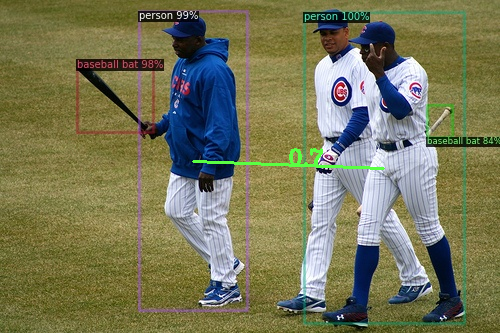

In [9]:
main('resnest', img, config_path, model_path)